# Testing OMD WGAN-GP with simple toy Gaussians

Tweaks: 
A. We use the Optimistic Adam optimizer:
    1. https://discuss.pytorch.org/t/optimistic-mirror-descent-in-saddle-point-problems-adam-optimizer-modification/26928
    2. https://openreview.net/forum?id=Bkg8jjC9KQ
    
B. The output of the discriminator is not a scalar, but a vector. The dimensionality of the vector affects the performance in convergence

In [1]:
%pylab inline 

import torch
import torch.nn as nn 
from torch import autograd

Populating the interactive namespace from numpy and matplotlib


## Goal: reconstruct a set of toy Gaussians, 4x4 on a square grid, 8 on a circular grid

In [2]:
# HyperParameters of the optimization
# for MLP
DEPTH = 6
WIDTH = 512


lr = 1.e-4
BATCH_SIZE = 256
ITERATIONS = 10**4
Z_DIM = 256 # Latent Space dimensionality
X_DIM = 2 # two dimensional Gaussian
NVIS = 100 # Visualizations
bbox = [-2.,2.,-2.,2.]

# Use GPU if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# @@@@@@@@@@ PERFORMANCE BOOST for pytorch @@@@@@@@@@@@@@@@@@@@@@@@@@@
torch.backends.cudnn.benchmark=True
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


In [3]:
# Visualize result
from scipy.stats import gaussian_kde
def kde(ax, mu, tau, bbox=None, xlabel="", ylabel="", cmap='Blues'):
    values = np.vstack([mu, tau])
    kernel = gaussian_kde(values,bw_method=.25)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    xx, yy = np.mgrid[bbox[0]:bbox[1]:300j, bbox[2]:bbox[3]:300j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    f = np.reshape(kernel(positions).T, xx.shape)
    cfset = ax.contourf(xx, yy, f, cmap=cmap)


# Create Data source generator - 4x4 grid of Gaussians
def x_real_builder(batch_size):
    sigma = 0.1
    skel = np.array([
        [ 1.50,  1.50],
        [ 1.50,  0.50],
        [ 1.50, -0.50],
        [ 1.50, -1.50],
        [ 0.50,  1.50],
        [ 0.50,  0.50],
        [ 0.50, -0.50],
        [ 0.50, -1.50],
        [-1.50,  1.50],
        [-1.50,  0.50],
        [-1.50, -0.50],
        [-1.50, -1.50],
        [-0.50,  1.50],
        [-0.50,  0.50],
        [-0.50, -0.50],
        [-0.50, -1.50],
    ])
    temp = np.tile(skel, (batch_size // 16 + 1,1))
    mus = temp[0:batch_size,:]
    return mus + sigma*np.random.randn(batch_size, X_DIM)


# Circular Gaussians data generator
class CircDataGenerator(object):
    """
    Reference: https://github.com/andrewliao11/unrolled-gans/blob/master/mixture_gaussian.py
    """
    def __init__(self):

        n = 8
        radius = 1.5
        std = 0.1
        delta_theta = 2*np.pi / n

        centers_x = []
        centers_y = []
        for i in range(n):
            centers_x.append(radius*np.cos(i*delta_theta))
            centers_y.append(radius*np.sin(i*delta_theta))

        centers_x = np.expand_dims(np.array(centers_x), 1)
        centers_y = np.expand_dims(np.array(centers_y), 1)

        p = [1./n for _ in range(n)]

        self.p = p
        self.size = 2
        self.n = n
        self.std = std
        self.centers = np.concatenate([centers_x, centers_y], 1)

    # switch to random distribution (harder)
    def random_distribution(self, p=None):
        if p is None:
            p = [np.random.uniform() for _ in range(self.n)]
            p = p / np.sum(p)
        self.p = p

    # switch to uniform distribution
    def uniform_distribution(self):
        p = [1./self.n for _ in range(self.n)]
        self.p = p

    def sample(self, N):
        n = self.n
        std = self.std
        centers = self.centers

        ith_center = np.random.choice(n, N,p=self.p)
        sample_centers = centers[ith_center, :]
        sample_points = np.random.normal(loc=sample_centers, scale=std)
        return sample_points.astype('float32')

## Visualize some toy data 

#### Square grid

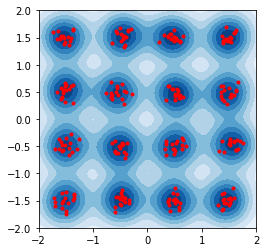

In [4]:
temp = x_real_builder(BATCH_SIZE)

fig, ax = plt.subplots()
ax.axis(bbox)
ax.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
kde(ax,temp[:,0],temp[:,1],bbox = bbox)
ax.plot(temp[:,0],temp[:,1],'r.')


### Circular grid 

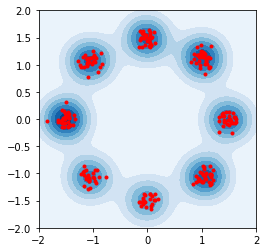

In [5]:
DataGen = CircDataGenerator()
temp = DataGen.sample(BATCH_SIZE)

fig, ax = plt.subplots()
ax.axis(bbox)
ax.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
kde(ax,temp[:,0],temp[:,1],bbox = bbox)
ax.plot(temp[:,0],temp[:,1],'r.')

In [6]:
# Another candy for visualizations
from IPython import display
def plot_fake_real(fig,epoch, fake, real, Wcost):
    fig.clf()
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(133)
    ax3 = fig.add_subplot(132)
    
    #ax1.axis(bbox)
    #ax1.set_aspect(abs(bbox[1]-bbox[0])/abs(bbox[3]-bbox[2]))
    
    treal = real.data.cpu().numpy()
    ax1.plot(treal[:,0],treal[:,1],'.',label='real')
    
    tfake = fake.data.cpu().numpy()
    ax1.plot(tfake[:,0],tfake[:,1],'+',label='fake')
    ax1.legend()
    
    # Kernel density estimation of fake 
    kde(ax3,tfake[:,0],tfake[:,1],bbox = bbox)
    ax3.plot(treal[:,0],treal[:,1],'r.',label='real')
    ax3.legend()
    
    
    ax2.plot(Wcost,'-',label = r'Wassrstn')
    ax2.set_xlabel(r'epoch')
    ax2.axhline(0.0,ls='--',c='r')
    
    tight_layout()
    
    fig.suptitle('Epoch:: {}'.format(epoch), size=20)
    
    display.clear_output(wait=True)
    display.display(gcf())


In [7]:
# Optimistic Mirror Adam - works GREAT 
import math
import torch
from torch.optim import Optimizer


class OptMirrorAdam(Optimizer):
    """
    Implements Optimistic Mirror Descent on Adam algorithm. 
    
        Built on official implementation of Adam by pytorch. 
       See "Optimistic Mirror Descent in Saddle-Point Problems: Gointh the Extra (-Gradient) Mile"
       double blind review, paper: https://openreview.net/pdf?id=Bkg8jjC9KQ 

    Standard Adam::

        It has been proposed in `Adam: A Method for Stochastic Optimization`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_

    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(OptMirrorAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(OptMirrorAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        
        loss = None
        
        # Do not allow training with out closure 
        if closure is  None:
            raise ValueError("This algorithm requires a closure definition for the evaluation of the intermediate gradient")
            
        
        # Create a copy of the initial parameters 
        param_groups_copy = self.param_groups.copy()
        
        # ############### First update of gradients ############################################
        # ######################################################################################
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # @@@@@@@@@@@@@@@ State initialization @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_1'] = torch.zeros_like(p.data)
                    state['exp_avg_2'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq_1'] = torch.zeros_like(p.data)
                    state['exp_avg_sq_2'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq_1'] = torch.zeros_like(p.data)
                        state['max_exp_avg_sq_2'] = torch.zeros_like(p.data)
                # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
                        
                        
                        
                        
                exp_avg1, exp_avg_sq1 = state['exp_avg_1'], state['exp_avg_sq_1']
                if amsgrad:
                    max_exp_avg_sq1 = state['max_exp_avg_sq_1']
                beta1, beta2 = group['betas']

                
                # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
                # Step will be updated once  
                state['step'] += 1
                # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
                
                
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg1.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq1.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                # *****************************************************
                # Additional steps, to get bias corrected running means  
                exp_avg1 = torch.div(exp_avg1, bias_correction1)
                exp_avg_sq1 = torch.div(exp_avg_sq1, bias_correction2)
                # *****************************************************
                                
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq1, exp_avg_sq1, out=max_exp_avg_sq1)
                    # Use the max. for normalizing running avg. of gradient
                    denom1 = max_exp_avg_sq1.sqrt().add_(group['eps'])
                else:
                    denom1 = exp_avg_sq1.sqrt().add_(group['eps'])

                step_size1 = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p.data.addcdiv_(-step_size1, exp_avg1, denom1)


        
        # Perform additional backward step to calculate stochastic gradient - WATING STATE 
        loss = closure()
        
        # Re run the optimization with the second averaged moments 
        # ############### Second evaluation of gradients ###########################################
        # ######################################################################################
        for (group, group_copy) in zip(self.param_groups,param_groups_copy ):
            for (p, p_copy) in zip(group['params'],group_copy['params']):
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                        
                        
                exp_avg2, exp_avg_sq2 = state['exp_avg_2'], state['exp_avg_sq_2']
                if amsgrad:
                    max_exp_avg_sq2 = state['max_exp_avg_sq_2']
                beta1, beta2 = group['betas']
                
                
                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg2.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq2.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # *****************************************************
                # Additional steps, to get bias corrected running means  
                exp_avg2 = torch.div(exp_avg2, bias_correction1)
                exp_avg_sq2 = torch.div(exp_avg_sq2, bias_correction2)
                # *****************************************************
                                
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq2, exp_avg_sq2, out=max_exp_avg_sq2)
                    # Use the max. for normalizing running avg. of gradient
                    denom2 = max_exp_avg_sq2.sqrt().add_(group['eps'])
                else:
                    denom2 = exp_avg_sq2.sqrt().add_(group['eps'])

                step_size2 = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                p_copy.data.addcdiv_(-step_size2, exp_avg2, denom2)
                p = p_copy
        
        
        
        
        return loss


## Some standard Linear models that work well

In [8]:
class MLP(nn.Module):
    """
    An MLP with hidden layers of the same width as the input.
    """

    def __init__(self,  depth, DIM, IN_DIM, OUT_DIM, act = nn.ReLU() ): 
        super(MLP, self).__init__()

        self.act = act # Our activation function         
        self.first = nn.Linear(in_features = IN_DIM, out_features=DIM) # First linear layer
        self.linears = nn.ModuleList([nn.Linear(in_features = DIM, out_features=DIM) for _ in range(depth-2)]) # This is a list of stacked layers 
        self.last = nn.Linear(in_features=DIM,out_features=OUT_DIM) # Last output layer
        

    def forward(self,x):
        x = self.first(x)
        x = self.act(x)
        for l in self.linears:
            x = l(x)
            x = self.act(x)
        # Note there is no activation here! This is a regression problem with arbitrary values
        x = self.last(x) 
        return x

In [9]:
# Standard Generator
netG = MLP(DEPTH, WIDTH, IN_DIM=Z_DIM, OUT_DIM=X_DIM).to(device) 
# Discriminator 
# Experiment with OUT_DIM=1, OUT_DIM=100 to see differences
netD = MLP(DEPTH+2, WIDTH,IN_DIM=X_DIM, OUT_DIM=X_DIM).to(device) 


# For WGAN-GP: 1-1 training, b1=0.0, b2 = 0.9
optG = OptMirrorAdam(netG.parameters(),lr=lr,betas=(0.0,0.9))
optD = OptMirrorAdam(netD.parameters(),lr=lr,betas=(0.0,0.9))

### Useful functions to calculate gradient penalty (only for D). 
$GradPnlty=\biggl\langle \biggl( \biggl|\frac{D(x)}{dx}\biggr|_{x=interpolates}-1 \biggr)^2\biggr\rangle_{batch}$

Note that the gradient penalty is estimated with respect to the input variable to the network, not the weights of the network! 

In [10]:
LAMBDA = 0.1
def calc_gradient_penalty(_netD, _real_data, _fake_data):
    alpha = torch.rand(_real_data.shape[0], 1).to(_real_data.device)
    alpha = alpha.expand(_real_data.size())
    # interpolates: a point "between" real and fake data. How does one define that for images?  
    interpolates = alpha * _real_data + ((1 - alpha) * _fake_data)
    interpolates.requires_grad=True

    disc_interpolates = _netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

## Standard Generator (z)

### Although it seems to converge fast, run up to 10k, or more, to get distribution match. 

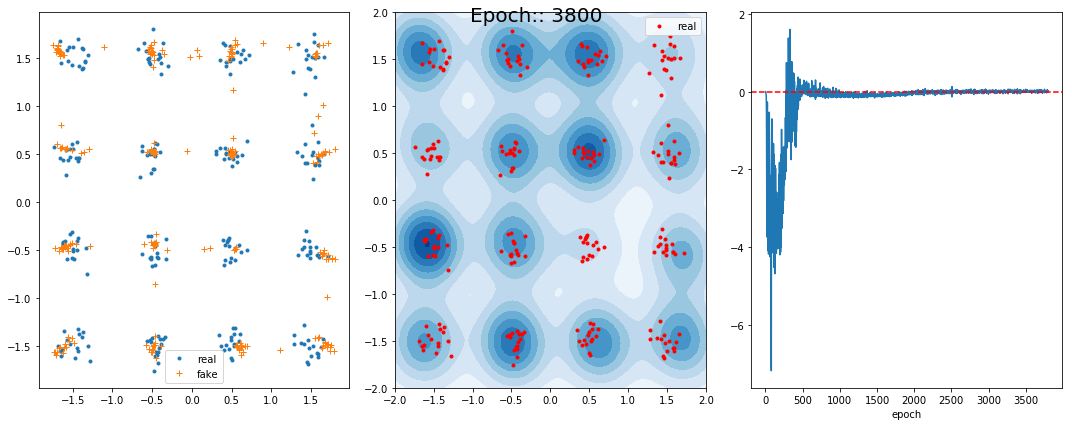

KeyboardInterrupt: 

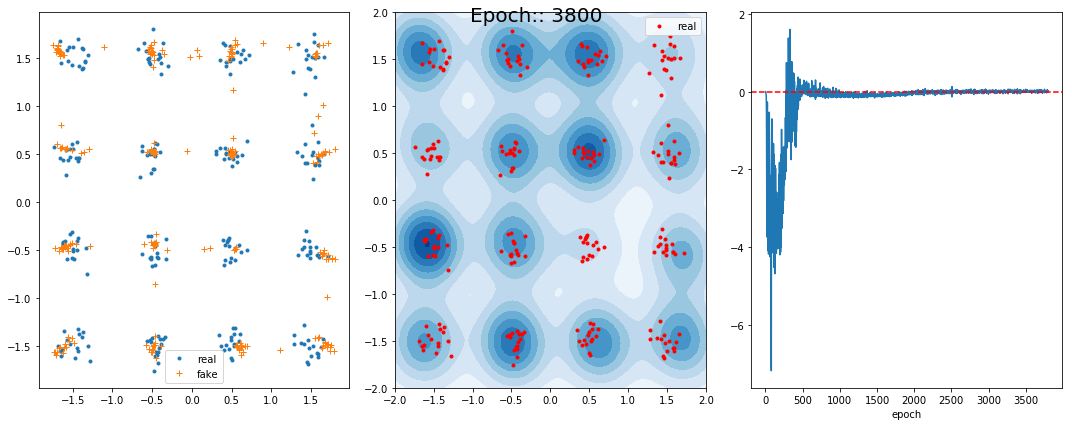

In [11]:
fig = figure(figsize=(15,6))
Wcost = []
netG.train()
netD.train()
for idx in range(ITERATIONS):

    
    optD.zero_grad()
    optG.zero_grad()
    
    # Update D Network
    # ########### Square gaussians data ########################################################## 
    x_real = torch.tensor(x_real_builder(BATCH_SIZE),dtype=torch.float32).to(device) # Square grid of Gaussians
    
    # ############### Circular Gaussians data ###################################################
    # x_real = torch.tensor(DataGen.sample(BATCH_SIZE),dtype=torch.float32).to(device) # Circular  Gaussians 
    
    noise = torch.randn(BATCH_SIZE,Z_DIM).to(device)
    
    x_fake = netG(noise).to(device).detach()
    
    disc_out_real = netD(x_real)
    disc_out_fake = netD(x_fake)
        
    grad_pnlty = LAMBDA* calc_gradient_penalty(netD, x_real,x_fake)
    Wasst = torch.mean(disc_out_fake.mean(dim=0)) - torch.mean(disc_out_real.mean(dim=0))
    Dloss = Wasst + grad_pnlty

    Wcost += [Wasst.data.cpu().numpy()]
    def closureD():
        netD.zero_grad()
        tnoise = torch.randn(BATCH_SIZE,Z_DIM).to(device)
        tx_fake = netG(tnoise).to(device).detach()
    
        tdisc_out_real = netD(x_real)
        tdisc_out_fake = netD(tx_fake)
        
        tgrad_pnlty = LAMBDA* calc_gradient_penalty(netD, x_real,tx_fake)
        tWasst = torch.mean(tdisc_out_fake.mean(dim=0)) - torch.mean(tdisc_out_real.mean(dim=0))
        tDloss = tWasst + tgrad_pnlty
        
        tDloss.backward()
        
        return tDloss
        
        
    Dloss.backward()
    optD.step(closureD)
    
    # Update G network     
    optG.zero_grad()
    
    noise = torch.randn(BATCH_SIZE,Z_DIM).to(device)
    x_fake = netG(noise).to(device)
    disc_out_fake = netD(x_fake)
    Gloss = - torch.mean(disc_out_fake.mean(dim=0)) #+gradPnltyG
    
    def closureG():
        netG.zero_grad()
    
        tnoise = torch.randn(BATCH_SIZE,Z_DIM).to(device)
        tx_fake = netG(tnoise).to(device)
        tdisc_out_fake = netD(tx_fake)
        tGloss = - torch.mean(tdisc_out_fake.mean(dim=0)) #+tgradPnltyG

        tGloss.backward()
        
        return tGloss
    
    
    Gloss.backward()
    optG.step(closureG)
    
    
    
    
    if (idx % NVIS == 0):
        plot_fake_real(fig,idx,x_fake,x_real, np.array(Wcost))
        
        